In [1]:
CSV_DIR = './colors_LAB.csv' # colors.csv, colors_LAB.csv, colors_LAB_512.csv, colors_RGB.csv, colors_RGB_512.csv
tf_model1= './Models/colors_model.tflite'
tf_model2= './Models/colors_model2.tflite'

#### 1. LOAD DATA

In [2]:
import pandas as pd
data = pd.read_csv(CSV_DIR, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,11830I_P2_01_02.png,38.084072,1.675187,0.546017,0.113031,55.194278,1.184798,1.607729,0.255833,79.570721,0.139387,2.941379,0.270448,67.787124,0.745390,2.569134,0.360688,Granodiorite
1,12720V_P2.JPG,36.131695,0.358650,0.812253,0.094667,78.647730,0.875534,2.974175,0.251521,55.297593,0.707808,1.892810,0.257838,66.937745,0.824929,2.722337,0.395974,Granodiorite
2,10715M_P2_01_02.png,26.302738,1.048009,1.684823,0.124619,44.377964,0.683518,2.874146,0.188599,69.600206,0.590402,2.807928,0.327001,57.868312,0.778340,2.816705,0.359781,Granodiorite
3,12723M_P2_01_02.png,29.963237,0.873753,-0.468336,0.152409,52.342383,1.315583,1.478690,0.219096,79.229780,0.322205,2.683711,0.303501,66.670959,0.943455,2.276501,0.324994,Granodiorite
4,11830I_P2_01_01.png,42.097614,-0.107062,4.496333,0.125494,57.336090,0.376883,3.278430,0.243064,79.928858,0.494999,1.475373,0.279441,69.286215,0.530661,2.089429,0.352001,Granodiorite


In [3]:
#data = data[data[17] != 'Diorite']
#data = data[data[17] != 'Gabbro']
#data = data[data[17] != 'Granite']
#data = data[data[17] != 'Granodiorite']
data = data[data[data.columns[-1]] != 'Tonalite'] # Deletes Tonalite
data = data[data[data.columns[-1]] != 'Monzodiorite'] # Deletes Monzodiorite

import numpy as np
x = np.array(data[data.columns[1:-1]])
y = data[data.columns[-1]]

print('x shape:', x.shape, '\ny shape:', y.shape)

x shape: (283, 16) 
y shape: (283,)


In [4]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
classes_dict = dict(zip( list(range(len(np.unique(y)))), encoder.inverse_transform(list(range(len(np.unique(y))))) ))

#classes_dict = {0: 'Diorite', 1: 'Granite', 2: 'Granodiorite', 3: 'Gabbro'}
#classes_dict = {0: 'Granodiorite', 1: 'Granite', 2: 'Diorite', 3: 'Gabbro'}
#y = np.array([list(classes_dict.keys())[list(classes_dict.values()).index(lbl)] for lbl in data[data.columns[-1]]])

print('Classes dict:', classes_dict)

Classes dict: {0: 'Diorite', 1: 'Gabbro', 2: 'Granite', 3: 'Granodiorite'}


In [5]:
classes, indices, counts = np.unique(y, return_counts=True, return_index=True)
df = pd.DataFrame({'Classes': classes_dict.values(), 'Counts': counts, 'Start index': indices}, classes)
df

,Classes,Counts,Start index
0,Diorite,78,140
1,Gabbro,65,218
2,Granite,70,70
3,Granodiorite,70,0


#### 2. SPLIT DATA

In [6]:
# Val = 20%, test = 16%, train = 64%
from sklearn.model_selection import train_test_split as splitter
#xtt, xval, ytt, yval = splitter(x,y,train_size=0.8,random_state=42)
xtrain, xtest, ytrain, ytest = splitter(x,y,train_size=0.8,random_state=42)

#### 3. NORMALIZE DATA

In [7]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()

xtrainNorm = normalizer.fit_transform(xtrain)
xtestNorm = normalizer.transform(xtest)

In [8]:
test_norms = [xtest[0][f]*normalizer.scale_[f]+normalizer.min_[f] for f in range(16)]
norm = {'Feature value': xtest[0], 'scale': normalizer.scale_, 'min': normalizer.min_, 'norm': test_norms, 'REAL NORM': xtestNorm[0]}
pd.DataFrame(norm)

,Feature value,scale,min,norm,REAL NORM
0,41.217477,0.015887,-0.314438,0.340392,0.340392
1,1.173219,0.247088,0.523440,0.813328,0.813328
2,1.368188,0.046562,0.132792,0.196497,0.196497
3,0.080054,5.213851,-0.219153,0.198235,0.198235
4,55.983387,0.016107,-0.344350,0.557360,0.557360
5,0.895888,0.266550,0.489189,0.727988,0.727988
6,3.504086,0.081916,0.343778,0.630819,0.630819
7,0.269345,6.258847,-0.700303,0.985483,0.985483
8,75.686828,0.016047,-0.345136,0.869422,0.869422
9,0.030723,0.300781,0.489749,0.498990,0.498990


#### 4. TRAINING an TESTING

In [9]:
from sklearn import metrics

In [10]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='lbfgs')
logReg.fit(xtrainNorm, ytrain)

print("<<MODELS REPORT LOG. REGRESSION>>")
print("Logistic Regression score:",logReg.score(xtestNorm, ytest))

predictions = logReg.predict(xtestNorm)
print("Logistic Regression Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

<<MODELS REPORT LOG. REGRESSION>>
Logistic Regression score: 0.631578947368421
Logistic Regression Model accuracy: 0.631578947368421
              precision    recall  f1-score   support

     Diorite       0.60      0.35      0.44        17
      Gabbro       0.50      0.77      0.61        13
     Granite       0.81      1.00      0.90        13
Granodiorite       0.64      0.50      0.56        14

    accuracy                           0.63        57
   macro avg       0.64      0.66      0.63        57
weighted avg       0.63      0.63      0.61        57



In [11]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xtrainNorm, ytrain)

print("<<MODEL REPORT KNN>>")
print("KNN score:",knn.score(xtestNorm, ytest))

predictions = knn.predict(xtestNorm)
print("KNN Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

<<MODEL REPORT KNN>>
KNN score: 0.9298245614035088
KNN Model accuracy: 0.9298245614035088
              precision    recall  f1-score   support

     Diorite       0.89      1.00      0.94        17
      Gabbro       0.93      1.00      0.96        13
     Granite       1.00      0.92      0.96        13
Granodiorite       0.92      0.79      0.85        14

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57



In [12]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(class_weight='balanced')
decisionTree.fit(xtrain, ytrain)

print("<<MODEL REPORT DT>>")
print("Decision trees score:",decisionTree.score(xtest, ytest))

predictions = decisionTree.predict(xtest)
print("Decision trees accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

<<MODEL REPORT DT>>
Decision trees score: 0.7017543859649122
Decision trees accuracy: 0.7017543859649122
              precision    recall  f1-score   support

     Diorite       0.75      0.71      0.73        17
      Gabbro       0.59      0.77      0.67        13
     Granite       0.80      0.92      0.86        13
Granodiorite       0.67      0.43      0.52        14

    accuracy                           0.70        57
   macro avg       0.70      0.71      0.69        57
weighted avg       0.70      0.70      0.69        57



In [13]:
# Support Vector Machines
from sklearn.svm import SVC
svmc = SVC(kernel='rbf', gamma='auto')
svmc.fit(xtrain, ytrain)

print("<<MODEL REPORT SVM>>")
print("Support Vector Machines:",svmc.score(xtest, ytest))

predictions = svmc.predict(xtest)
print("Support Vector Machines Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

<<MODEL REPORT SVM>>
Support Vector Machines: 0.8070175438596491
Support Vector Machines Model accuracy: 0.8070175438596491
              precision    recall  f1-score   support

     Diorite       0.92      0.71      0.80        17
      Gabbro       0.68      1.00      0.81        13
     Granite       0.87      1.00      0.93        13
Granodiorite       0.80      0.57      0.67        14

    accuracy                           0.81        57
   macro avg       0.82      0.82      0.80        57
weighted avg       0.83      0.81      0.80        57



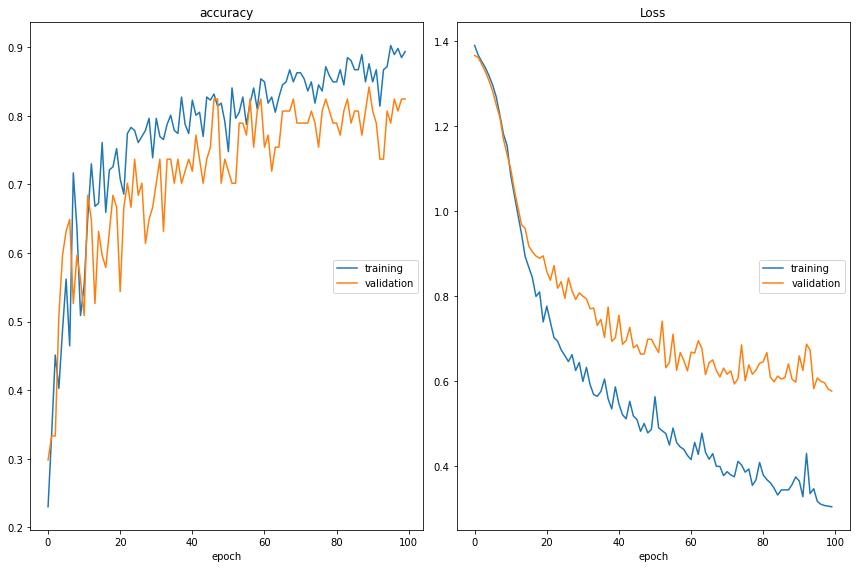

accuracy
	training         	 (min:    0.230, max:    0.903, cur:    0.894)
	validation       	 (min:    0.298, max:    0.842, cur:    0.825)
Loss
	training         	 (min:    0.305, max:    1.390, cur:    0.305)
	validation       	 (min:    0.577, max:    1.366, cur:    0.577)
Accuracy: 0.825 Loss: 0.577
CNN Model accuracy: 0.8245614035087719
              precision    recall  f1-score   support

     Diorite       0.87      0.76      0.81        17
      Gabbro       0.81      1.00      0.90        13
     Granite       0.93      1.00      0.96        13
Granodiorite       0.67      0.57      0.62        14

    accuracy                           0.82        57
   macro avg       0.82      0.83      0.82        57
weighted avg       0.82      0.82      0.82        57

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            96        
__

In [14]:
# Convolutional Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import optimizers
from livelossplot.inputs.tf_keras import PlotLossesCallback

model = Sequential()
model.add(Conv1D(32, kernel_size=2, padding="same", input_shape = (16, 1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(classes_dict), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=["accuracy"])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

xtrain2 = np.expand_dims(xtrainNorm, 2); ytrain2 = np.expand_dims(ytrain, 1)
xtest2 = np.expand_dims(xtestNorm, 2); ytest2 = np.expand_dims(ytest, 1)

model.fit(xtrain2, ytrain2, epochs=100, batch_size=32, 
          validation_data=(xtest2, ytest2), callbacks=[PlotLossesCallback()], 
          verbose=1)

loss, acc = model.evaluate(xtest2, ytest2, verbose=0)
print('Accuracy: %.3f' % acc, 'Loss: %.3f' % loss)

predictions = np.argmax(model.predict(xtest2), axis=-1)
print("CNN Model accuracy:", metrics.accuracy_score(ytest2, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

model.summary()

In [15]:
import tensorflow as tf

class KNN(tf.Module):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors; self.xtr = None; self.ytr = None
        
    def fit(self, x, y):
        self.xtr = np.float32(x); self.ytr = y
        
    def score(self, xte, yte):
        accuracy = 0.0
        for i in range (len(xte)):
            prediction = self.predict(xte[i])
            print("Test %d, and the prediction is %s, the real value is %s"%(i, prediction.numpy(), yte[i]))
            if prediction == yte[i]:
                accuracy += 1. / len(xte)
        return accuracy
    
    @tf.function
    def predict(self, value):
        value = tf.cast(value, tf.float32)
        # MANHATTAN distances
        distances = tf.abs(tf.reduce_sum(tf.square(tf.subtract(self.xtr, value)), axis=1))
        # The top k values and their indices. We multiply the distance by -1 to reverse the magnitude of distances,so the largest distance becomes the smallest distance.
        knn_values, knn_indices = tf.nn.top_k(tf.scalar_mul(-1,distances),k=self.n_neighbors)
        # We locate the exact class label set of the k closest matches in the training data
        best_training_labels = tf.gather(self.ytr,knn_indices)
        # We make our prediction based on the class label that appears most frequently
        if self.n_neighbors==1:
            prediction = tf.squeeze([best_training_labels])
        else:
            values, indices, counts = tf.unique_with_counts(best_training_labels)
            max_count_index = tf.argmax(counts,0)
            prediction = tf.gather(values, max_count_index)
        return best_training_labels

knn_model = KNN(1)
knn_model.fit(xtrainNorm, ytrain)
print('TF-KNN score:', knn_model.score(xtestNorm, ytest))
print(knn_model.predict(xtestNorm[0]))

concrete_func = knn_model.predict.get_concrete_function(tf.TensorSpec(shape=[16], dtype=tf.float32))
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Save the model.
with open(tf_model1, 'wb') as f:
    f.write(tflite_model)

Test 0, and the prediction is [3], the real value is 3
Test 1, and the prediction is [1], the real value is 1
Test 2, and the prediction is [2], the real value is 2
Test 3, and the prediction is [0], the real value is 0
Test 4, and the prediction is [2], the real value is 2
Test 5, and the prediction is [1], the real value is 1
Test 6, and the prediction is [1], the real value is 1
Test 7, and the prediction is [0], the real value is 0
Test 8, and the prediction is [3], the real value is 3
Test 9, and the prediction is [0], the real value is 0
Test 10, and the prediction is [1], the real value is 3
Test 11, and the prediction is [1], the real value is 1
Test 12, and the prediction is [0], the real value is 0
Test 13, and the prediction is [1], the real value is 1
Test 14, and the prediction is [3], the real value is 3
Test 15, and the prediction is [0], the real value is 0
Test 16, and the prediction is [1], the real value is 1
Test 17, and the prediction is [0], the real value is 0
Te

In [16]:
# TF KNN
# Resource: https://stackoverflow.com/questions/45787046/tensorflow-knn-how-can-we-assign-the-k-parameter-for-defining-number-of-neighb

import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()

#tf.float64
knn_size=1
colors = tf1.placeholder(dtype=tf1.float32, shape=[len(xtrainNorm[0])])
# MANHATTAN distances
distances = tf1.abs(tf1.reduce_sum(tf1.square(tf1.subtract(np.float32(xtrainNorm), colors)),axis=1))
# The top k values and their indices. We multiply the distance by -1 to reverse the magnitude of distances,so the largest distance becomes the smallest distance.
knn_values, knn_indices = tf1.nn.top_k(tf.scalar_mul(-1,distances),k=knn_size)
# We locate the exact class label set of the k closest matches in the training data
best_training_labels = tf1.gather(ytrain,knn_indices)

# We make our prediction based on the class label that appears most frequently
if knn_size==1:
    prediction = tf1.squeeze(best_training_labels)
else:
    values, indices, counts = tf1.unique_with_counts(best_training_labels)
    max_count_index = tf1.argmax(counts,0)
    prediction = tf1.gather(values, max_count_index)

# Convert to TF Lite format
with tf1.Session() as sess:
    accuracy = 0.0
    for i in range (len(xtestNorm)):
        prediction_value = sess.run([prediction], feed_dict={colors:xtestNorm[i]})
        print("Test %d, and the prediction is %s, the real value is %s"%(i,prediction_value[0],ytest[i]))
        if prediction_value[0] == ytest[i]:
            accuracy += 1. / len(ytest)
    print('TF KNN Accuracy -> ', accuracy * 100, ' %')
        
    converter = tf1.lite.TFLiteConverter.from_session(sess, [colors], [best_training_labels])
    tflite_model = converter.convert()

# Save the model.
with open(tf_model2, 'wb') as f:
    f.write(tflite_model)

Test 0, and the prediction is 3, the real value is 3
Test 1, and the prediction is 1, the real value is 1
Test 2, and the prediction is 2, the real value is 2
Test 3, and the prediction is 0, the real value is 0
Test 4, and the prediction is 2, the real value is 2
Test 5, and the prediction is 1, the real value is 1
Test 6, and the prediction is 1, the real value is 1
Test 7, and the prediction is 0, the real value is 0
Test 8, and the prediction is 3, the real value is 3
Test 9, and the prediction is 0, the real value is 0
Test 10, and the prediction is 1, the real value is 3
Test 11, and the prediction is 1, the real value is 1
Test 12, and the prediction is 0, the real value is 0
Test 13, and the prediction is 1, the real value is 1
Test 14, and the prediction is 3, the real value is 3
Test 15, and the prediction is 0, the real value is 0
Test 16, and the prediction is 1, the real value is 1
Test 17, and the prediction is 0, the real value is 0
Test 18, and the prediction is 1, the 

In [17]:
import tensorflow as tf
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./Models/colors_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('Input shape:', input_details[0]['shape'], '- Output shape:', output_details[0]['shape'])

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.float32(xtestNorm[0])
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('\nFor data', input_data, '\nResult is', output_data, 'which is', classes_dict[output_data[0]])

Input shape: [16] - Output shape: [1]

For data [0.34039184 0.813328   0.19649698 0.19823523 0.55735976 0.7279878
 0.63081855 0.9854832  0.86942196 0.49899033 0.53998494 0.28122786
 0.68260825 0.6431427  0.3984993  0.35193524] 
Result is [3] which is Granodiorite
